In [42]:
# Terminal / Anaconda Navigator: conda install -c conda-forge gensim
import pickle
from gensim import matutils, models, corpora
import scipy.sparse
import pandas as pd
from gensim.models import LdaMulticore, CoherenceModel

In [64]:
f_data = pd.read_csv('../data/NegativeTweets.csv')
f_data.head(3)

,Datetime,Tweet Id,OriginalText,Username,Text_Cleaned,tokens,Text,Subjectivity,Polarity,NumberOfWords,MeanWordLength,P&SSentiment,SIA Positive Sentiment,SIA Neutral Sentiment,SIA Negative Sentiment
0,2021-10-27 23:39:35+00:00,1453506696094142469,@1goonrich Buy Dogus and make it 700k mc #NFTG...,aacryp,buy dogus and make it mc kishu hoge froge dog...,"['buy', 'dogus', 'make', 'kishu', 'hoge', 'fro...",buy dogus make kishu hoge froge doge dogus thi...,0.427273,-0.131818,29,5.69,Negative,0.000001,1.000001,0.000001
1,2021-10-27 23:32:41+00:00,1453504957991292933,💧 SupreSpace Metaverse 2nd Round Airdrop 💧\n\n...,AirdropStario,suprespace metaverse round airdrop task up to...,"['suprespace', 'round', 'airdrop', 'task', 'sa...",suprespace round airdrop task sapce referral s...,0.400000,-0.200000,10,6.60,Negative,0.000001,1.000001,0.000001
2,2021-10-27 23:31:03+00:00,1453504546345455619,@Elite_Portraits is now LIVE hand-crafting the...,DeployStarShip,is now live hand crafting the artwork for the ...,"['live', 'hand', 'crafting', 'artwork', 'plane...",live hand crafting artwork planet game claim p...,0.450000,-0.131818,14,5.93,Negative,0.198001,0.802001,0.000001


In [65]:
f_data = f_data.loc[f_data['Datetime'] >= '2021-11-10']

In [66]:
f_data = f_data.loc[f_data['Datetime'] <= '2021-11-12']

In [67]:
f_data

,Datetime,Tweet Id,OriginalText,Username,Text_Cleaned,tokens,Text,Subjectivity,Polarity,NumberOfWords,MeanWordLength,P&SSentiment,SIA Positive Sentiment,SIA Neutral Sentiment,SIA Negative Sentiment
1461,2021-11-10 23:58:36+00:00,1458584908943826949,Clearly broke down :D I blame the markets and ...,ARedcrypto,clearly broke downi blame the markets and btc ...,"['clearly', 'broke', 'downi', 'blame', 'market...",clearly broke downi blame markets hopium obser...,0.435714,0.121429,26,5.42,Positive,0.165001,0.619001,0.215001
1462,2021-11-10 23:50:42+00:00,1458582922794086403,@SupreSpace Breaking News: The Earth version o...,garmavich,breaking news the earth version of will be lau...,"['breaking', 'news', 'earth', 'version', 'laun...",breaking news earth version launched december ...,0.500000,-0.500000,15,5.93,Negative,0.372001,0.628001,0.000001
1463,2021-11-10 23:43:51+00:00,1458581196850581511,All manipulation paper hands sold and now we b...,AyeeZeeeee,all manipulation paper hands sold and now we b...,"['manipulation', 'paper', 'hands', 'sold', 'bu...",manipulation paper hands sold buy dip back moo...,0.000000,0.000000,10,5.00,Neutral,0.000001,0.804001,0.196001
1464,2021-11-10 23:39:51+00:00,1458580190347542528,#Meta the announcement video for the #Metavers...,GardnerConverse,the announcement video for the was so awkward ...,"['announcement', 'video', 'awkward', 'mark', '...",announcement video awkward mark zuckerburg som...,0.533333,-0.250000,13,7.31,Negative,0.000001,0.882001,0.118001
1465,2021-11-10 23:39:24+00:00,1458580080519696388,Are you following @Metaciple yet!? \n\nHe may ...,MakeupLoveer,are you following yet he may beterrible gamer ...,"['following', 'yet', 'may', 'beterrible', 'gam...",following yet may beterrible gamer worst aim a...,0.625000,-0.065909,18,5.89,Negative,0.159001,0.669001,0.172001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1618,2021-11-11 22:15:39+00:00,1458921388643962897,@BenBuckwalter Why Choose #FLOKI Valhalla #Met...,PaInIaMs,why choose valhalla upgradeable valhalla scarc...,"['choose', 'valhalla', 'upgradeable', 'valhall...",choose valhalla upgradeable valhalla scarce ge...,0.525000,-0.100000,23,6.83,Negative,0.083001,0.917001,0.000001
1619,2021-11-11 22:15:39+00:00,1458921388010618880,Verasity in Top 10 gaming Tokes by Market Capi...,kindasset,verasity in top gaming tokes by market capita...,"['verasity', 'top', 'gaming', 'tokes', 'market...",verasity top gaming tokes market capitalizatio...,0.387500,0.150000,22,6.32,Positive,0.075001,0.833001,0.092001
1620,2021-11-11 22:15:27+00:00,1458921338459111428,"Let's aim for more #EXP and #NFTs rewards , on...",flexy_ahs,letaim for more and rewards once we start to p...,"['letaim', 'rewards', 'start', 'play', 'later'...",letaim rewards start play later donmissed laun...,0.200000,-0.200000,11,5.55,Negative,0.497001,0.503001,0.000001
1621,2021-11-11 22:13:11+00:00,1458920769254309890,@ProTheDoge Why Choose #FLOKI Valhalla #Metave...,PaInIaMs,why choose valhalla upgradeable valhalla scarc...,"['choose', 'valhalla', 'upgradeable', 'valhall...",choose valhalla upgradeable valhalla scarce ge...,0.525000,-0.100000,23,6.83,Negative,0.083001,0.917001,0.000001


In [68]:
# We are going to create a document-term matrix using CountVectorizer, and exclude common English stop words
from sklearn.feature_extraction.text import CountVectorizer

# Vedi pickle
cv = CountVectorizer(stop_words='english')
data_cv = cv.fit_transform(f_data.Text)
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_dtm.index = f_data.index

In [69]:
# One of the required inputs is a term-document matrix
tdm = data_dtm.transpose()
tdm.head()

,1461,1462,1463,1464,1465,1466,1467,1468,1469,1470,...,1613,1614,1615,1616,1617,1618,1619,1620,1621,1622
abilities,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
aboutlive,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
accepting,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
acquire,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
action,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [70]:
# We're going to put the term-document matrix into a new gensim format, from df --> sparse matrix --> gensim corpus
sparse_counts = scipy.sparse.csr_matrix(data_dtm)
corpus = matutils.Sparse2Corpus(sparse_counts)

In [71]:
# Gensim also requires dictionary of the all terms and their respective location in the term-document matrix
cv = pickle.load(open("../data/cv_stop.pkl", "rb"))
id2word = dict((v, k) for k, v in cv.vocabulary_.items())

/usr/local/lib/python3.9/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.18.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [72]:
# Now that we have the corpus (term-document matrix) and id2word (dictionary of location: term),
# we need to specify two other parameters as well - the number of topics and the number of passes # Now that we have the corpus (term-document matrix) and id2word (dictionary of location: term),
# we need to specify two other parameters as well - the number of topics and the number of passes
lsi = models.LsiModel(corpus, 3, id2word = id2word)
lsi.print_topics()

[(0,
  '-0.535*"ali" + -0.535*"alienate" + -0.322*"agagagain" + -0.232*"absorbing" + -0.200*"affection" + -0.194*"agrees" + -0.148*"advantage" + -0.116*"alien" + -0.113*"african" + -0.111*"ah"'),
 (1,
  '0.509*"abc" + 0.509*"abcs" + 0.509*"ability" + 0.199*"adopting" + 0.149*"actions" + 0.149*"acting" + 0.149*"acquisitions" + 0.094*"al" + 0.087*"aidsthat" + 0.087*"achieve"'),
 (2,
  '0.460*"acquisitions" + 0.460*"acting" + 0.460*"actions" + -0.366*"advantage" + 0.176*"activate" + -0.125*"aisha" + -0.125*"albany" + 0.115*"ali" + 0.115*"alienate" + -0.101*"absofuckinglutely"')]

In [73]:
# Let's create a function to pull out nouns from a string of text
from nltk import word_tokenize, pos_tag

def nouns(text):
    '''Given a string of text, tokenize the text and pull out only the nouns.'''
    is_noun = lambda pos: pos[:2] == 'NN'
    tokenized = word_tokenize(text)
    all_nouns = [word for (word, pos) in pos_tag(tokenized) if is_noun(pos)]
    return ' '.join(all_nouns)

In [74]:
# Apply the nouns function to the transcripts to filter only on nouns
data_nouns = pd.DataFrame(f_data.Text.apply(nouns))
data_nouns

,Text
1461,blame markets observation dip run tries retrac...
1462,news earth version december retweet tag friend...
1463,manipulation paper hands moon mission ufo
1464,announcement video mark zuckerburg somehow peo...
1465,gamer aim innovator creator boundaries space
...,...
1618,valhalla valhalla scarce genesis game power ab...
1619,verasity gaming tokes market capitalization da...
1620,letaim rewards launching game play dge
1621,valhalla valhalla scarce genesis game power ab...


In [75]:
# Create a new document-term matrix using only nouns
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer

# Re-add the additional stop words since we are recreating the document-term matrix
add_stop_words = ['like', 'im', 'know', 'just', 'dont', 'thats', 'right', 'people',
                  'youre', 'got', 'gonna', 'time', 'think', 'yeah', 'said']
stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

# Recreate a document-term matrix with only nouns
cvn = CountVectorizer(stop_words=stop_words)
data_cvn = cvn.fit_transform(data_nouns.Text)
data_dtmn = pd.DataFrame(data_cvn.toarray(), columns=cvn.get_feature_names())
data_dtmn.index = data_nouns.index
data_dtmn

,abilities,action,advantage,advice,advisor,age,aim,airdrop,alonegreat,alsobig,...,yazin,year,years,yon,yukari,zil,zombie,zuck,zuckerburg,zucks
1461,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1462,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1463,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1464,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1465,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1618,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1619,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1620,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1621,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [76]:
# Create the gensim corpus
corpusn = matutils.Sparse2Corpus(scipy.sparse.csr_matrix(data_dtmn.transpose()))

# Create the vocabulary dictionary
id2wordn = dict((v, k) for k, v in cvn.vocabulary_.items())

In [77]:
# Let's try topics = 3
lsin = models.LsiModel(corpusn, 3, id2word = id2wordn)
lsin.print_topics()

[(0,
  '-0.856*"game" + -0.240*"valhalla" + -0.146*"developers" + -0.126*"team" + -0.120*"power" + -0.120*"items" + -0.118*"abilities" + -0.118*"marketing" + -0.118*"genesis" + -0.118*"scarce"'),
 (1,
  '-0.432*"discord" + -0.357*"check" + -0.321*"twitter" + -0.290*"retweet" + -0.273*"look" + -0.273*"server" + -0.273*"computer" + -0.273*"apes" + -0.273*"letlet" + -0.174*"join"'),
 (2,
  '0.488*"way" + 0.389*"join" + 0.308*"change" + 0.213*"ownership" + 0.207*"donbe" + -0.168*"valhalla" + 0.165*"today" + 0.154*"income" + 0.154*"creatingfuture" + 0.154*"view"')]

In [78]:
# Let's create a function to pull out nouns from a string of text
def nouns_adj(text):
    '''Given a string of text, tokenize the text and pull out only the nouns and adjectives.'''
    is_noun_adj = lambda pos: pos[:2] == 'NN' or pos[:2] == 'JJ'
    tokenized = word_tokenize(text)
    nouns_adj = [word for (word, pos) in pos_tag(tokenized) if is_noun_adj(pos)]
    return ' '.join(nouns_adj)

In [79]:
# Apply the nouns function to the transcripts to filter only on nouns
data_nouns_adj = pd.DataFrame(f_data.Text.apply(nouns_adj))
data_nouns_adj

,Text
1461,downi blame markets hopium observation dip set...
1462,news earth version december retweet tag friend...
1463,manipulation paper hands dip moon mission ufo
1464,announcement video mark zuckerburg somehow rob...
1465,gamer worst aim hean amazing innovator creator...
...,...
1618,choose valhalla upgradeable valhalla scarce ge...
1619,verasity top gaming tokes market capitalizatio...
1620,letaim rewards launching game play dge
1621,choose valhalla upgradeable valhalla scarce ge...


In [80]:
# Create a new document-term matrix using only nouns and adjectives, also remove common words with max_df
cvna = CountVectorizer(stop_words=stop_words, max_df=.8)
data_cvna = cvna.fit_transform(data_nouns_adj.Text)
data_dtmna = pd.DataFrame(data_cvna.toarray(), columns=cvna.get_feature_names())
data_dtmna.index = data_nouns_adj.index
data_dtmna

,abilities,aboutlive,action,active,advantage,advice,advisor,afraid,age,aim,...,yazin,year,years,yon,yukari,zil,zombie,zuck,zuckerburg,zucks
1461,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1462,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1463,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1464,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1465,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1618,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1619,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1620,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1621,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [81]:
# Create the gensim corpus
corpusna = matutils.Sparse2Corpus(scipy.sparse.csr_matrix(data_dtmna.transpose()))

# Create the vocabulary dictionary
id2wordna = dict((v, k) for k, v in cvna.vocabulary_.items())

In [83]:
# Let's try 3 topics
ldana = models.LsiModel(corpus=corpusna, num_topics=8, id2word=id2wordna)
ldana.print_topics()

[(0,
  '-0.806*"game" + -0.243*"valhalla" + -0.146*"developers" + -0.127*"team" + -0.122*"power" + -0.121*"items" + -0.120*"scarce" + -0.120*"marketing" + -0.120*"burnable" + -0.120*"ups"'),
 (1,
  '0.414*"real" + 0.371*"check" + 0.275*"discord" + 0.229*"twitter" + 0.224*"internet" + 0.212*"retweet" + 0.204*"server" + 0.204*"look" + 0.204*"letlet" + 0.204*"computer"'),
 (2,
  '-0.407*"way" + -0.311*"join" + -0.260*"change" + -0.260*"perceive" + -0.199*"donbe" + 0.185*"valhalla" + -0.179*"ownership" + -0.148*"discord" + -0.142*"digital" + -0.139*"today"'),
 (3,
  '0.265*"discord" + -0.263*"live" + -0.260*"tech" + -0.229*"williams" + -0.206*"minutes" + -0.206*"lead" + -0.206*"meet" + -0.206*"writer" + -0.206*"timecoo" + 0.186*"internet"'),
 (4,
  '0.242*"virtual" + -0.232*"game" + 0.202*"valhalla" + 0.185*"way" + 0.184*"land" + 0.181*"join" + 0.156*"world" + 0.141*"location" + 0.141*"url" + 0.141*"avatar"'),
 (5,
  '0.280*"world" + 0.260*"years" + 0.260*"life" + 0.233*"difficult" + 0.177

In [84]:
from gensim import corpora
word2id = dict((k, v) for k, v in cvna.vocabulary_.items())
d = corpora.Dictionary()
d.id2token = id2word
d.token2id = word2id

In [250]:
# supporting function
def compute_coherence_values(corpus, dictionary, k):
    lsi_model = models.LsiModel(corpus=corpus, num_topics=k, id2word=dictionary)
    coherence_model_lda = CoherenceModel(model=lsi_model, corpus=corpus,dictionary=dictionary, coherence='u_mass')
    return coherence_model_lda.get_coherence()

In [251]:
compute_coherence_values(corpusna,d,2)

-11.868115201124464

In [252]:
import numpy as np
from gensim import models
# Topics range
min_topics = 2
max_topics = 10
step_size = 1
topics_range = range(min_topics, max_topics, step_size)
# Alpha parameter
# Validation sets
model_results = {
                 'Topics': [],
                 'Coherence': []
                }

# Can take a long time to run
if 1 == 1:
        # iterate through number of topics
    for k in topics_range:

                    # get the coherence score for the given parameters
        cv = compute_coherence_values(corpus=corpusna, dictionary=d,
                                                  k=k)
                    # Save the model results
        model_results['Topics'].append(k)
        model_results['Coherence'].append(cv)

In [253]:
model_results

{'Topics': [2, 3, 4, 5, 6, 7, 8, 9],
 'Coherence': [-11.921655520225741,
  -12.220053865115704,
  -14.015426242012786,
  -14.33420610647114,
  -13.921296728846398,
  -14.452054908598395,
  -12.806295910708108,
  -14.234763733714901]}

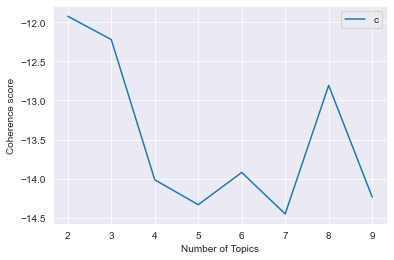

In [254]:
import matplotlib.pyplot as plt
def plot_graph(model_results):
    plt.plot(model_results['Topics'], model_results['Coherence'])
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend("coherence_values", loc='best')
    plt.show()

plot_graph(model_results)

In [255]:
results = pd.DataFrame(model_results)

In [256]:
results.to_csv("../data/resultsLSI062022.csv",index=False)